In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn import preprocessing
import math
from sklearn.ensemble import RandomForestClassifier

## Data Structuring

In [2]:
df_juan = pd.read_csv("..//resources//csv//data//biometrics-juan.csv")
df_rocio = pd.read_csv("..//resources//csv//data//biometrics-rocio.csv")
df_matias = pd.read_csv("..//resources//csv//data//biometrics-matias.csv")
df_bren = pd.read_csv("..//resources//csv//data//biometrics-bren.csv")

In [3]:
dfs = [df_rocio, df_juan, df_matias, df_bren]

In [4]:
def standarize(df):
    df_to_standarize = df.copy()
    
    # remover las mediciones sin estímulo antes de la estandarización, para no afectar la desviación
    filterArousal = df_to_standarize['ArousalMean'] > 0
    filtered1 = df_to_standarize[filterArousal]

    # remover las mediciones para las que el sam no coincidió antes de la estandarización, para no afectar la desviación
    # filterSam = filtered1['MatchesSam'] == True
    # filtered = filtered1[filterSam]
    
    columns_to_standarize = ['HR', 'HRV', 'MicroSiemens']

    scaler = preprocessing.StandardScaler()
    standarized_df = scaler.fit_transform(df_to_standarize[columns_to_standarize])

    standarized_df_with_arousal = np.append(standarized_df, df_to_standarize[['ArousalMean']], axis=1)

    # Convert it to dataframe
    standarized_df_with_arousal = pd.DataFrame(standarized_df_with_arousal, columns=['HR', 'HRV', 'MicroSiemens', 'ArousalMean'])

    return standarized_df_with_arousal

In [5]:
# Se estandariza cada dataframe
standarized_dfs = list(map(standarize, dfs))

# Se los une a todos en un solo dataframe para entrenamiento luego de la estandarización
biometrics_df = pd.concat(standarized_dfs)

# sns.pairplot(biometrics_df, height=3.5);
# plt.show()

## Correlation Analysis

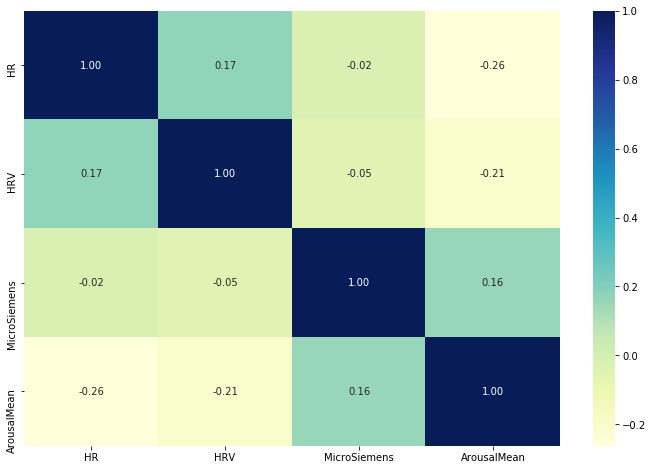

In [6]:
plt.figure(figsize=(12,8))
sns.heatmap(biometrics_df.corr(), annot=True, fmt=".2f", cmap='YlGnBu')
# plt.show()

# Model creation

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [8]:
X = biometrics_df[['MicroSiemens', 'HR', 'HRV' ]].values
y = biometrics_df['ArousalMean'].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [10]:
# Para poder usar un clasificador, los datos de la variable target deben ser discretos.
#Los convertimos a True-False (Aroused-NotAroused) con el fin de poder entrear un clasificador binario
def map_to_0_and_1(arousal):
    return 0 if arousal < 5 else 1

y_train_aroused = np.array(list(map(map_to_0_and_1, y_train)))
y_test_aroused = np.array(list(map(map_to_0_and_1, y_test)))

In [16]:
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score
def print_score(clf, X_train, X_test, y_train, y_test, train=True):
    '''
    v0.1 Follow the scikit learn library format in terms of input
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_train)
    if train:
        '''
        training performance
        '''
        res = clf.predict(X_train)
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, 
                                                                res)))
        print("Classification Report: \n {}\n".format(classification_report(y_train, 
                                                                            res)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, 
                                                                  res)))
        print("ROC AUC: {0:.4f}\n".format(roc_auc_score(lb.transform(y_train), 
                                                      lb.transform(res))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        '''
        test performance
        '''
        res_test = clf.predict(X_test)
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, 
                                                                res_test)))
        print("Classification Report: \n {}\n".format(classification_report(y_test, 
                                                                            res_test)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, 
                                                                  res_test)))   
        print("ROC AUC: {0:.4f}\n".format(roc_auc_score(lb.transform(y_test), 
                                                      lb.transform(res_test))))
        

In [17]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train_aroused)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# Prediction

In [18]:
rf_clf.predict(X[145].reshape(1, -1))

array([0])

# TRAIN Performance Measuring

In [19]:
print_score(rf_clf, X_train, X_test, y_train_aroused, y_test_aroused, train=True)
print("\n******************************\n")
print_score(rf_clf, X_train, X_test, y_train_aroused, y_test_aroused, train=False)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1304
           1       1.00      1.00      1.00       517

    accuracy                           1.00      1821
   macro avg       1.00      1.00      1.00      1821
weighted avg       1.00      1.00      1.00      1821


Confusion Matrix: 
 [[1304    0]
 [   0  517]]

ROC AUC: 1.0000

Average Accuracy: 	 0.6232
Accuracy SD: 		 0.0751

******************************

Test Result:

accuracy score: 0.5351

Classification Report: 
               precision    recall  f1-score   support

           0       0.57      0.81      0.67       263
           1       0.39      0.17      0.23       193

    accuracy                           0.54       456
   macro avg       0.48      0.49      0.45       456
weighted avg       0.49      0.54      0.48       456


Confusion Matrix: 
 [[212  51]
 [161  32]]

ROC AUC: 0.4859



# Grid Search

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [22]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
params_grid = {"max_depth": [3, None],
               "min_samples_split": [2, 3, 10],
               "min_samples_leaf": [1, 3, 10],
               "bootstrap": [True, False],
               "criterion": ['gini', 'entropy']}

In [23]:
grid_search = GridSearchCV(rf_clf, params_grid,
                           n_jobs=-1, cv=5,
                           verbose=1, scoring='accuracy',
                           iid=False)

In [25]:
grid_search.fit(X_train, y_train_aroused)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.4min finished
C:\Users\alons\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [26]:
grid_search.best_score_

0.7128029504741834

In [27]:
grid_search.best_estimator_.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [29]:
print_score(grid_search, X_train, X_test, y_train_aroused, y_test_aroused, train=True)
print("\n******************************\n")
print_score(grid_search, X_train, X_test, y_train_aroused, y_test_aroused, train=False)

Train Result:

accuracy score: 0.7161

Classification Report: 
               precision    recall  f1-score   support

           0       0.72      1.00      0.83      1304
           1       0.00      0.00      0.00       517

    accuracy                           0.72      1821
   macro avg       0.36      0.50      0.42      1821
weighted avg       0.51      0.72      0.60      1821


Confusion Matrix: 
 [[1304    0]
 [ 517    0]]

ROC AUC: 0.5000

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\alons\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.9min finished
C:\Users\alons\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.5min finished
C:\Users\alons\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.4min finished
C:\Users\alons\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   51.9s finished
C:\Users\alons\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   41.4s finished
C:\Users\alons\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   40.2s finished
C:\Users\alons\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   37.8s finished
C:\Users\alons\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   37.1s finished
C:\Users\alons\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   39.6s finished
C:\Users\alons\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   39.3s finished
C:\Users\alons\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Average Accuracy: 	 0.7111
Accuracy SD: 		 0.0100

******************************

Test Result:

accuracy score: 0.5768

Classification Report: 
               precision    recall  f1-score   support

           0       0.58      1.00      0.73       263
           1       0.00      0.00      0.00       193

    accuracy                           0.58       456
   macro avg       0.29      0.50      0.37       456
weighted avg       0.33      0.58      0.42       456


Confusion Matrix: 
 [[263   0]
 [193   0]]

ROC AUC: 0.5000



C:\Users\alons\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
y_test_pred_grid = grid_search.predict(X_test)

In [31]:
df_y_train = pd.DataFrame(data=y_test_aroused, columns=['Arousal'])
df_y_pred = pd.DataFrame(data=y_test_pred_grid, columns=['Arousal'])

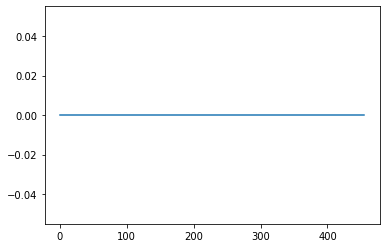

In [32]:
plt.plot(df_y_pred["Arousal"])
plt.show()

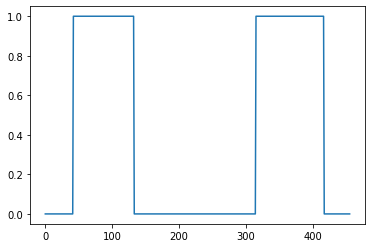

In [33]:
plt.plot(df_y_train["Arousal"])
plt.show()